## Global Black Box Optimization with RNNS

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import benchmarkfunctions as fun
print(tf.__version__)

1.1.0


In [2]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernel(x,X)
    return 2*(np.squeeze(np.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return 2*(tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

In [3]:
def gen_data(n_train, n_test, n_gp_samples = 8):
    
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples, 2))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))

    # Compute and invert the GP Kernel Matrix
    K_XX = kernel(X,X)
    A = np.linalg.inv(K_XX)
    A = np.matmul(A,np.expand_dims(Y,axis=2))
    
    # Compute min and max
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)

    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    y = GP(X,A,x,minv = -1.0, maxv = 1.0)
    
    min_val = np.min(y,1).reshape(-1,1)
    max_val = np.max(y,1).reshape(-1,1)
    
    Y = 2*(Y-min_val)/(max_val-min_val)-1
    
    return (X, Y, A, min_val, max_val)

In [4]:
def plot_data_3D(X,A,min_val, max_val):
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)
    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    XX1, XX2 = np.meshgrid(xx1,xx2)
    y = GP(X,A,x,min_val, max_val)
    
    fig = plt.figure(figsize=(20,6))
    for i in range(3):
        ax1 = fig.add_subplot(1,3,1+i, projection='3d')
        ax1.plot_surface(XX1, XX2, y[i].reshape(100,100), cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)
        ax1.scatter3D(X[i,:,1], X[i,:,0], Y[i,:], color = "k")
    plt.show()
    
def plot_data_heat(X,A,min_val, max_val):
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)
    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    y = GP(X,A,x,min_val, max_val)
    
    plt.figure(figsize=(20,6))
    for i in range(3):
        plt.subplot(1,3,1+i)
        plt.imshow(y[i].reshape(100,100), cmap='hot', interpolation='nearest', extent=[-1,1,1,-1])
        plt.colorbar()
        plt.scatter(X[i,:,1], X[i,:,0], color = "b", marker = "x")
        plt.xlim([-1,1])
        plt.ylim([-1,1])
    plt.show()

In [5]:
n_train = 1600
n_test = 16
n_gp_samples = 8

X, Y, A, min_val, max_val = gen_data(n_train, n_test, n_gp_samples=8)

X_train, Y_train, A_train, min_train, max_train = \
    X[:n_train], Y[:n_train], A[:n_train], min_val[:n_train], max_val[:n_train]

X_test, Y_test, A_test, min_test, max_test = \
    X[-n_test:], Y[-n_test:], A[-n_test:], min_val[-n_test:], max_val[-n_test:]

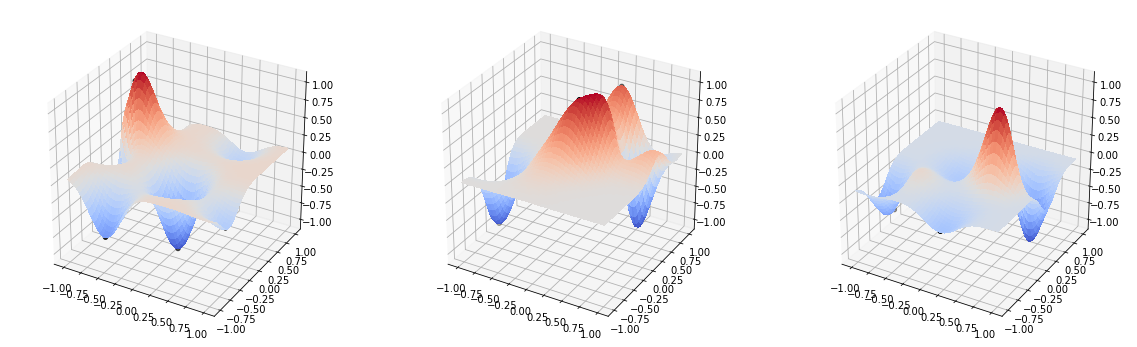

In [6]:
plot_data_3D(X,A,min_val, max_val)

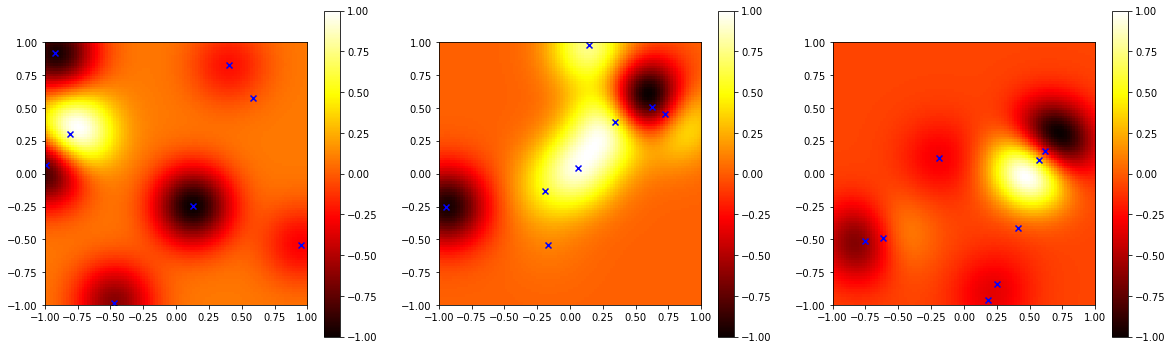

In [7]:
plot_data_heat(X,A,min_val, max_val)

In [8]:
# Number of hidden states in RNN cell
n_hidden = 200

# Sequence length
num_steps = 10

In [9]:
# LSTM Output Weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, 2]))
}
biases = {
    'out': tf.Variable(tf.random_normal([2]))
}

In [10]:
# Create Model

size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_gp_samples, 2])
At = tf.placeholder(tf.float32, [None, n_gp_samples, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, 2])
h_0 = tf.ones([size, n_hidden])
c_0 = tf.ones([size, n_hidden])

state = (c_0, h_0)
x = x_0
y = GPTF(Xt,At,x, mint, maxt)
sample_points = [x]

f_min = y
f_sum = 0

# No idea why this is necessary 
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
cell(tf.concat([x, y], 1), state, scope='rnn_cell')
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

for i in range(num_steps):
    h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
    x = tf.tanh(tf.matmul(h, weights['out']) + biases['out'])
    sample_points.append(x)
    
    y = GPTF(Xt,At,x, mint, maxt)
    
    f_min = tf.minimum(y, f_min)
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = f_sum / num_steps

In [11]:
learning_rate = 0.00001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
#train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []
test_fmin_list = []

In [13]:
# Train the Network
epochs = 200
batch_size = 160

print("Number of Training Samples: "+str(n_train))
print("Batch size: "+str(batch_size))
print("Number of hidden Units: "+str(n_hidden))
print("Sequence length: "+ str(num_steps))
print("Learning rate: "+str(learning_rate))

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
        A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
        min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
        max_batch = max_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={Xt: X_batch, At: A_batch, size: batch_size, mint: min_batch, maxt: max_batch})
    
    train_loss, train_fmin = sess.run([loss, f_min], \
                          feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})

    test_loss, test_fmin = sess.run([loss, f_min], \
                                    feed_dict={Xt: X_test, At: A_test, size:n_test, mint: min_test, maxt: max_test})
    
    train_loss_list += [train_loss]
    test_loss_list += [test_loss]
    train_fmin_list += [train_fmin]
    test_fmin_list += [test_fmin]
    
    if ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1:
        print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
              +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
              "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin)+" |")
        
    if train_fmin < -0.95:
        print("Stopped training: TrainMin < -0.95")
        break

Number of Training Samples: 1600
Batch size: 160
Number of hidden Units: 200
Sequence length: 10
Learning rate: 1e-05
Ep:    0 | TrainLoss:  0.023 | TrainMin: -0.253 | TestLoss: -0.050 | TestMin: -0.443 |
Ep:    1 | TrainLoss:  0.012 | TrainMin: -0.216 | TestLoss: -0.058 | TestMin: -0.340 |
Ep:    2 | TrainLoss:  0.003 | TrainMin: -0.189 | TestLoss: -0.070 | TestMin: -0.285 |
Ep:    3 | TrainLoss: -0.000 | TrainMin: -0.172 | TestLoss: -0.070 | TestMin: -0.260 |
Ep:    4 | TrainLoss: -0.001 | TrainMin: -0.163 | TestLoss: -0.069 | TestMin: -0.239 |
Ep:    5 | TrainLoss: -0.002 | TrainMin: -0.159 | TestLoss: -0.069 | TestMin: -0.231 |
Ep:    6 | TrainLoss: -0.002 | TrainMin: -0.157 | TestLoss: -0.069 | TestMin: -0.228 |
Ep:    7 | TrainLoss: -0.002 | TrainMin: -0.155 | TestLoss: -0.069 | TestMin: -0.227 |
Ep:    8 | TrainLoss: -0.002 | TrainMin: -0.154 | TestLoss: -0.069 | TestMin: -0.225 |
Ep:    9 | TrainLoss: -0.002 | TrainMin: -0.154 | TestLoss: -0.069 | TestMin: -0.224 |
Ep:   20 | T

In [14]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train, 2).transpose((1,0,2))
samples_test = sess.run([sample_points], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test, 2).transpose((1,0,2))

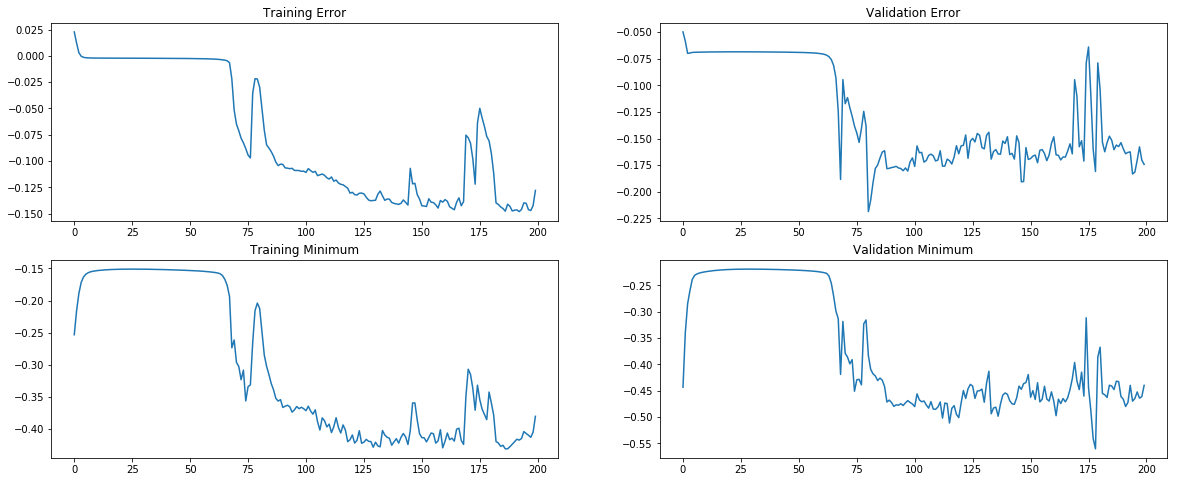

In [15]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(2,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.subplot(2,2,3)
plt.plot(train_fmin_list)
plt.title("Training Minimum")
plt.subplot(2,2,4)
plt.plot(test_fmin_list)
plt.title("Validation Minimum")
plt.show()

In [16]:
def plot_result(traintest = "train", nplot = 9):
    if traintest == "train":
        X, A, minv, maxv = (X_train, A_train, min_train, max_train)
        samples = samples_train
        nf = n_train
    else:
        X, A, minv, maxv  = (X_test, A_test, min_test, max_test)
        samples = samples_test
        nf = n_test
        
    # Data for Plotting
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)
    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    y = GP(X,A,x,minv, maxv, l = 0.3)
    
    b = np.ceil(np.sqrt(nplot))
    a = np.ceil(nplot/b)
    idx = np.random.choice(list(range(nf)),nplot, replace=False)

    plt.figure(figsize=(20,18))
    for count, i in enumerate(idx):
        plt.subplot(a,b,1+count)
        plt.imshow(y[i].reshape(100,100), cmap='hot', interpolation='nearest', extent=[-1,1,1,-1])
        plt.colorbar()
        plt.scatter(samples[i,:,1], samples[i,:,0], color = "b", marker = "x")
        for j in range(1+num_steps):
            plt.text(samples[i,j,1], samples[i,j,0], str(j), color="green", fontsize=12)
        plt.xlim([-1,1])
        plt.ylim([-1,1])
    plt.show()

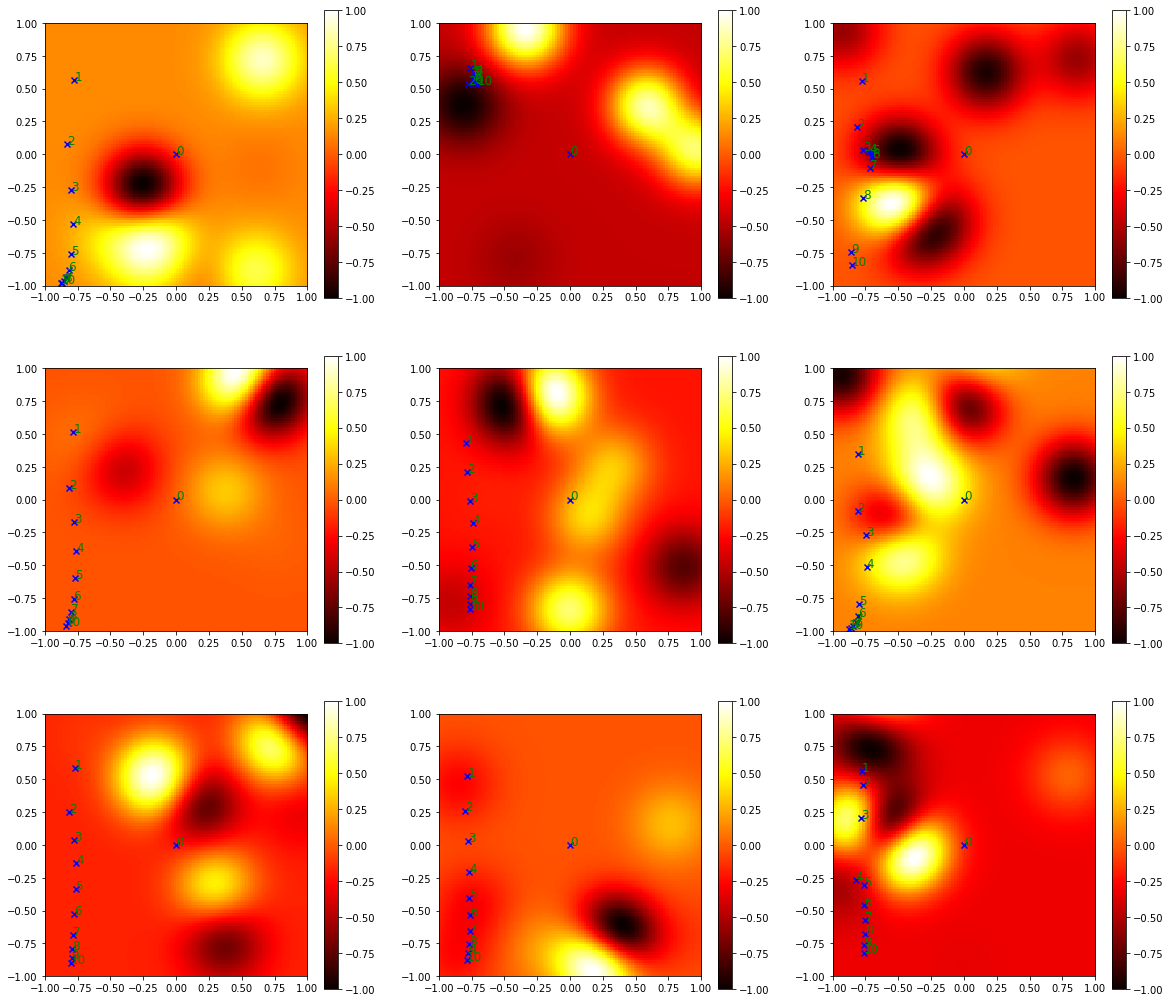

In [17]:
plot_result("train",9)

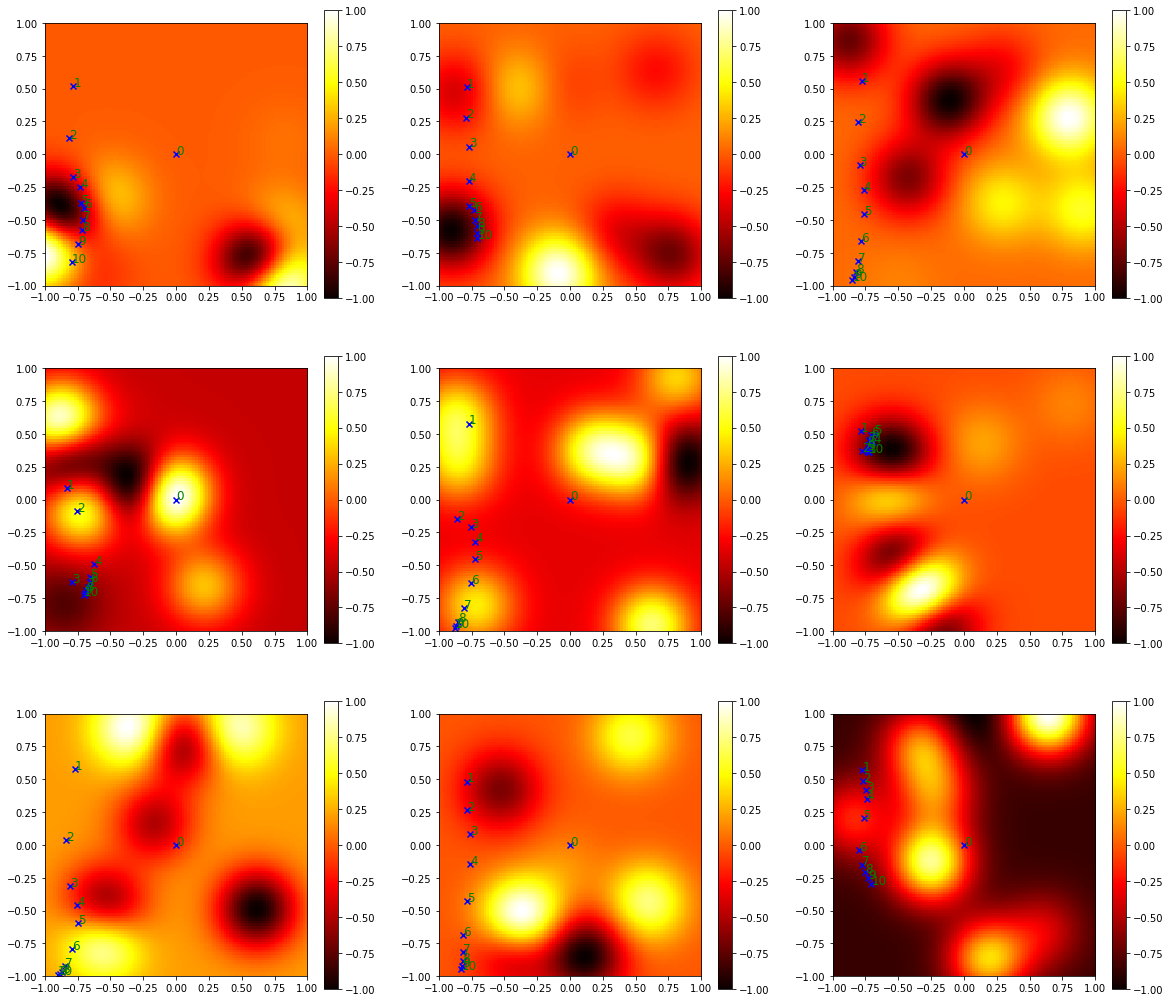

In [18]:
plot_result("test")